<a href="https://colab.research.google.com/github/dyna-bytes/PyTorchIntensive/blob/main/4_1_GoogleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GoogleNet, Inception-v1

In [ ]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'[{_str}]:')
        _str = ''
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}')

In [ ]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics torchviz

### Module import

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import functional as FM
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import CSVLogger
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from IPython import display
plt.rcParams['figure.figsize'] = [5, 3.5]

device ='cuda:0'
torch.__version__

'2.0.1+cu118'

### 구조를 보기위해 간략화한 코드
> LRN -> BN, Aux clasifier 생략, test를 위해 Class 1000 -> 5

* Conv2d(in_c, out_c, kernel_size, stride, padding)


In [ ]:
## Conv2d(in_c, out_c, kernel_size, stride, padding)

def conv_1(in_dim,out_dim):
    module = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,1,1), #(in,out,kernel_size,stride)
        nn.ReLU())
    return module

def conv_1_3(in_dim,mid_dim,out_dim):
    module = nn.Sequential(
        nn.Conv2d(in_dim,mid_dim,1,1),
        nn.ReLU(),
        nn.Conv2d(mid_dim,out_dim,3,1,1),
        nn.ReLU())
    return module

def conv_1_5(in_dim,mid_dim,out_dim):
    module = nn.Sequential(
        nn.Conv2d(in_dim,mid_dim,1,1),
        nn.ReLU(),
        nn.Conv2d(mid_dim,out_dim,5,1,2),
        nn.ReLU())
    return module

def max_3_1(in_dim,out_dim):
    module = nn.Sequential(
        nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
        nn.Conv2d(in_dim,out_dim,1,1),
        nn.ReLU())
    return module

In [ ]:
# Inception 모듈 정의
class inception_module(nn.Module):
    def __init__(self,in_dim,out_dim_1,mid_dim_3,out_dim_3,mid_dim_5,out_dim_5,pool_dim):
        super(inception_module,self).__init__()
        # 1x1 Convolution
        self.conv_1 = conv_1(in_dim,out_dim_1)
        # 1x1 Convolution -> 3x3 Convolution
        self.conv_1_3 = conv_1_3(in_dim,mid_dim_3,out_dim_3)
        # 1x1 Convolution -> 5x5 Convolution
        self.conv_1_5 = conv_1_5(in_dim,mid_dim_5,out_dim_5)
        # 3x3 MaxPooling -> 1x1 Convolution
        self.max_3_1 = max_3_1(in_dim,pool_dim)

    def forward(self,x):
        out_1 = self.conv_1(x)
        out_2 = self.conv_1_3(x)
        out_3 = self.conv_1_5(x)
        out_4 = self.max_3_1(x)
        # concat
        output = torch.cat([out_1,out_2,out_3,out_4],1)#(bs,c,h,w)
        return output

In [ ]:
# Conv2d(in_c, out_c, kernel_size, stride, padding)

from IPython.core.display import ProgressBar
batch_size = 16
loss_function = nn.CrossEntropyLoss()

class GoogLeNet(pl.LightningModule):
    def __init__(self, base_dim=64, num_classes=1000):
        super(GoogLeNet, self).__init__()
        self.num_classes=num_classes
        self.layer_1 = nn.Sequential(
            nn.Conv2d(3,base_dim,7,2,3),
            nn.BatchNorm2d(base_dim),
            nn.MaxPool2d(3,2,1),
            nn.Conv2d(base_dim,base_dim*3,3,1,1),
            nn.BatchNorm2d(base_dim*3),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_2 = nn.Sequential(
            inception_module(base_dim*3,64,96,128,16,32,32),  #256=64+128+32+32
            inception_module(base_dim*4,128,128,192,32,96,64),#480
            nn.MaxPool2d(3,2,1),
        )
        self.layer_3 = nn.Sequential(
            inception_module(480,192,96,208,16,48,64),        #512
            inception_module(512,160,112,224,24,64,64),       #512
            inception_module(512,128,128,256,24,64,64),       #512
            inception_module(512,112,144,288,32,64,64),       #528
            inception_module(528,256,160,320,32,128,128),     #832
            nn.MaxPool2d(3,2,1),
        )
        self.layer_4 = nn.Sequential(
            inception_module(832,256,160,320,32,128,128),     #832
            inception_module(832,384,192,384,48,128,128),     #1024
            nn.AvgPool2d(7,1),
        )
        self.layer_5 = nn.Dropout2d(0.4)
        self.fc_layer = nn.Linear(1024,self.num_classes)

    def forward(self, x):
        out = self.layer_1(x)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)  #(bs,1024,1,1)
        out = self.layer_5(out)
        out = out.view(-1, 1024) #(bs,1024)
        out = self.fc_layer(out) #(bs,classes)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=5)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=5)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [ ]:
img_shape = (224, 224, 3)
model = GoogLeNet()
#model = GoogLeNet(num_classes=5)
summary(model, input_size=(16, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
GoogLeNet                                [16, 1000]                --
├─Sequential: 1-1                        [16, 192, 28, 28]         --
│    └─Conv2d: 2-1                       [16, 64, 112, 112]        9,472
│    └─BatchNorm2d: 2-2                  [16, 64, 112, 112]        128
│    └─MaxPool2d: 2-3                    [16, 64, 56, 56]          --
│    └─Conv2d: 2-4                       [16, 192, 56, 56]         110,784
│    └─BatchNorm2d: 2-5                  [16, 192, 56, 56]         384
│    └─MaxPool2d: 2-6                    [16, 192, 28, 28]         --
├─Sequential: 1-2                        [16, 480, 14, 14]         --
│    └─inception_module: 2-7             [16, 256, 28, 28]         --
│    │    └─Sequential: 3-1              [16, 64, 28, 28]          12,352
│    │    └─Sequential: 3-2              [16, 128, 28, 28]         129,248
│    │    └─Sequential: 3-3              [16, 32, 28, 28]         

In [ ]:
model

GoogLeNet(
  (layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): inception_module(
      (conv_1): Sequential(
        (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
      (conv_1_3): Sequential(
        (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
      (conv_1_5): Sequential(
        (0): Conv2d(192, 16, kernel_siz

In [ ]:
torch.onnx.export(model, torch.zeros(32, 3, 224, 224).to(device), 'GoogLeNet.onnx')

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



OnnxExporterError: ignored

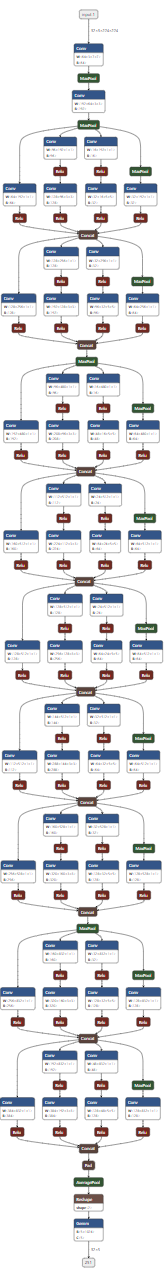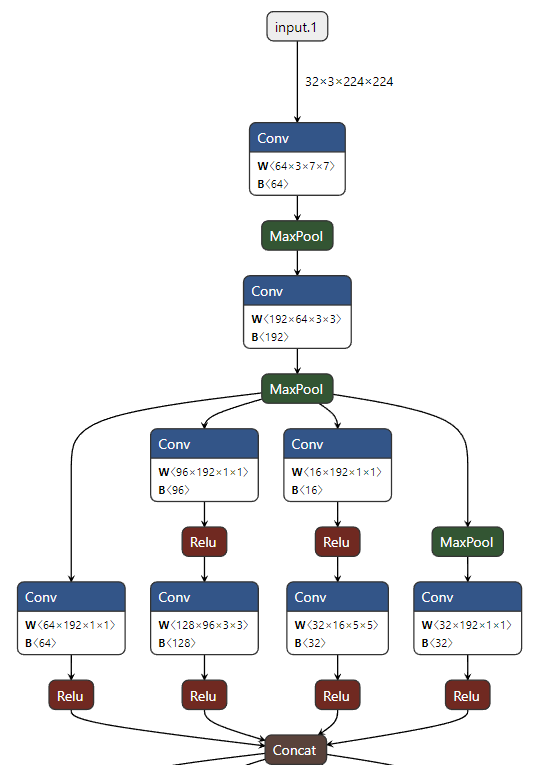

# 실습과제
1. Flower Photos dataset으로 학습하기
* model을 수정해서 생성하자
* Dataset을 준비하자
* Training 및 성능을 확인 하자
2. Pre-trained GoogLeNet모델과 성능을 비교해 보자
* 모델을 load하고
* 성능을 확인하자


### Flower Photos 학습하기

#### **Dataset Load**

##### ImageFolde(), DataLoader() 사용

In [ ]:
from torchvision.datasets.utils import download_and_extract_archive

dataset_url = \
      "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
root = './'
data_dir='Dataset'
download_and_extract_archive(dataset_url, root, data_dir)
data_dir = root+data_dir+'/flower_photos'
data_dir

100%|██████████| 228813984/228813984 [00:01<00:00, 179599663.74it/s]


Extracting ./flower_photos.tgz to Dataset


'./Dataset/flower_photos'

In [ ]:
!ls {data_dir}

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


In [ ]:
!rm -r 'flower_photos_sp'

rm: cannot remove 'flower_photos_sp': No such file or directory


##### Train / Test Data split

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
import pathlib

sp_path="flower_photos_sp"
splitfolders.ratio(data_dir, output=sp_path,
    seed=1337, ratio=(.7, .3), group_prefix=None, move=True )
sp_train = pathlib.Path(sp_path+'/train')
sp_test = pathlib.Path(sp_path+'/val')
sp_train

Copying files: 3670 files [00:00, 6442.53 files/s]


PosixPath('flower_photos_sp/train')

##### Check Images

In [ ]:
# 지정 폴더 아래에 있는 모든 *.jpg 파일의 수
#  및 폴더명 목록을 리턴
def check_dir(d_path):
    img_count = len(list(d_path.glob('*/*.jpg')))
    c_name = np.array([item.name for item in d_path.glob('*') if item.name != "LICENSE.txt"])
    return img_count, c_name, len(c_name)

# check_dir()로 폴더명과 이미지 숫자 확인
image_count, CLASS_train, class_num = check_dir(sp_train)
CLASS_train.sort()
print('Train image_count: {}\nclasses: {}'.format(image_count, CLASS_train))
image_count, CLASS_test, class_num = check_dir(sp_test)
CLASS_test.sort()
print('Test image_count: {}\nclasses: {}'.format(image_count, CLASS_test))

Train image_count: 2567
classes: ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']
Test image_count: 1103
classes: ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [ ]:
# 지정 path 아래에 있는 폴더에서 이미지 두장씩을 확인
def check_image(d_path, class_list):
    for i in range(len(class_list)):
        class_temp = list(d_path.glob(str(class_list[i])+'/*'))
        for image_path in class_temp[:2]:
            display.display(Image.open(str(image_path)))
# check_image()로 이미지 두장씩 확인
check_image(sp_train, CLASS_train)

#### ImageFolder, DataLoader 적용

In [ ]:
# Imagae size 결정 **
IN_IMG_SIZE = 224
batch_n = 64

In [ ]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

## loader에 적용할 transform
train_transforms = transforms.Compose([transforms.Resize((IN_IMG_SIZE, IN_IMG_SIZE)),
#                              transforms.RandomAffine(degrees=40, translate=(0.2, 0.2), shear=0.2),
                              transforms.RandomResizedCrop(IN_IMG_SIZE, scale=[0.8, 1.0]),
                              transforms.RandomHorizontalFlip(0.5),
                              transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize((IN_IMG_SIZE, IN_IMG_SIZE)),
                              transforms.ToTensor()])

## ImageFolder : folder로 구성된 image set을 위한 loader
train_imgs = ImageFolder(sp_train, transform=train_transforms) #(image,label)
test_imgs = ImageFolder(sp_test, transform=test_transforms)

## DataLoader : dataset과 sampler를 결합 batch단위 제공 #(image,label)*batch
train_loader = DataLoader(train_imgs, batch_size=batch_n, shuffle=True, num_workers=4)
test_loader = DataLoader(test_imgs, batch_size=batch_n, shuffle=False, num_workers=4)

len(train_imgs),len(test_imgs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(2567, 1103)

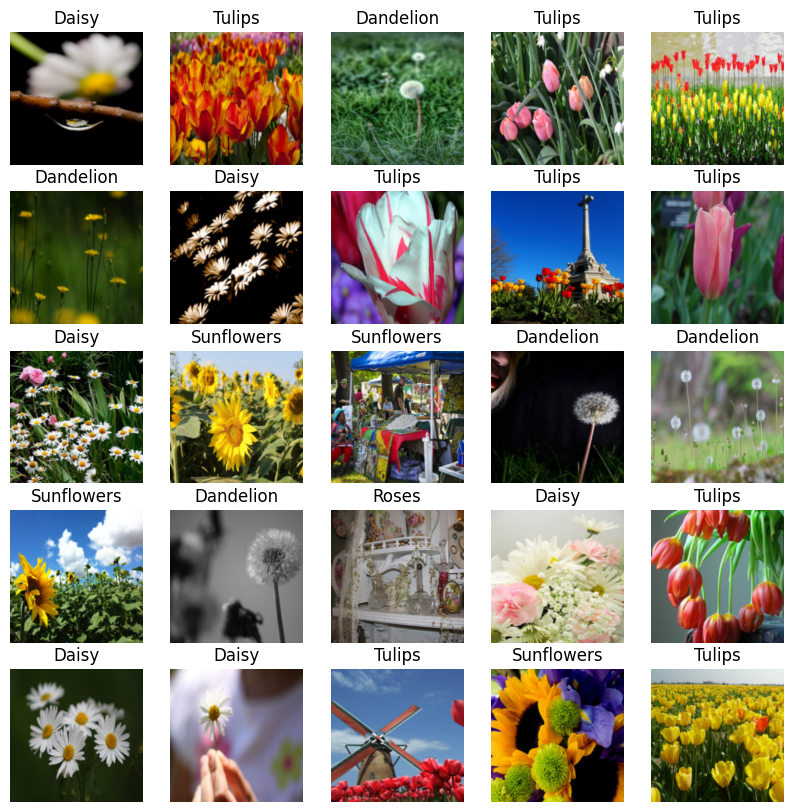

In [ ]:
def show_batch(data_gen, class_l):
    # get image and label from data generator
    img_batch, l_batch = next(iter(data_gen))
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(img_batch[n].permute(1, 2, 0))
        plt.title(class_l[l_batch[n]].title())
        plt.axis('off')
    return img_batch, l_batch

# check dataset
_,_ = show_batch(train_loader, CLASS_train)
#_,_ = show_batch(test_loader, CLASS_test)

#### Training

In [ ]:
%%time
model = GoogLeNet(num_classes=5)

epochs=50
logger = CSVLogger("logs", name="googLeNet")
trainer = Trainer(max_epochs=epochs, logger=logger, accelerator='auto',
                  limit_train_batches=1.0, limit_val_batches=1.0)
trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params
----------------------------------------
0 | layer_1  | Sequential | 120 K 
1 | layer_2  | Sequential | 552 K 
2 | layer_3  | Sequential | 2.8 M 
3 | layer_4  | Sequential | 2.5 M 
4 | layer_5  | Dropout2d  | 0     
5 | fc_layer | Linear   

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


CPU times: user 4min 12s, sys: 45.8 s, total: 4min 58s
Wall time: 18min 53s


Epoch 49: 100%
59/59 [00:13<00:00, 4.52it/s, loss=0.212, v_num=12, val_loss=0.967, val_acc=0.743]
CPU times: user 7min 16s, sys: 2min 6s, total: 9min 23s
Wall time: 10min 52s

#### Analysis

In [ ]:
v_num = logger.version
history1 = pd.read_csv(f'./logs/googLeNet/version_{v_num}/metrics.csv')
history1_plot = history1.drop('step', axis=1).groupby('epoch').mean()

In [ ]:
history1_plot = history1_plot.dropna()

In [ ]:
history1_plot

,val_loss,val_acc,loss,acc
epoch,,,,
1,1.322457,0.399819,1.586472,0.265625
2,1.528600,0.327289,1.308087,0.437500
3,1.305427,0.408885,1.223747,0.406250
4,1.352193,0.371714,1.269606,0.312500
6,1.143946,0.498640,1.145544,0.546875
7,1.117370,0.502267,1.053638,0.484375
8,1.117742,0.475068,1.276575,0.437500
9,1.284657,0.440616,1.035029,0.546875
10,1.221667,0.513146,0.925662,0.578125


	 0.7833182215690613


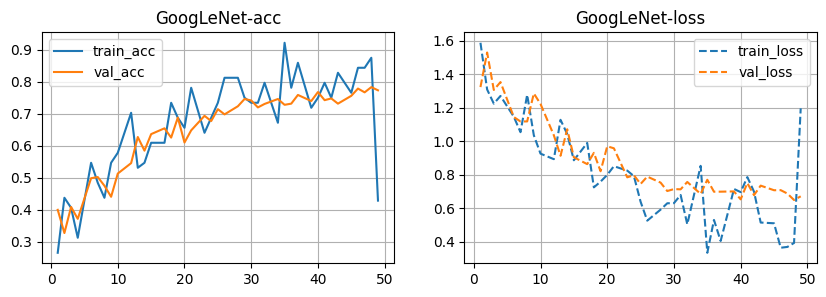

In [ ]:
import matplotlib.pylab as plt
print('\t',np.max(history1_plot['val_acc']))

fig = plt.figure(figsize = (10, 3))
plt.subplot(121)
plt.plot(history1_plot['acc'], linestyle='-', label="train_acc")
plt.plot(history1_plot['val_acc'], linestyle='-', label="val_acc")
plt.title("GoogLeNet-acc")
#plt.ylim(0.1, 1)
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(history1_plot['loss'], linestyle='--', label="train_loss")
plt.plot(history1_plot['val_loss'], linestyle='--', label="val_loss")
plt.title("GoogLeNet-loss")
#plt.ylim(0.1, 1)
plt.legend()
plt.grid()
plt.show()

0.773345410823822
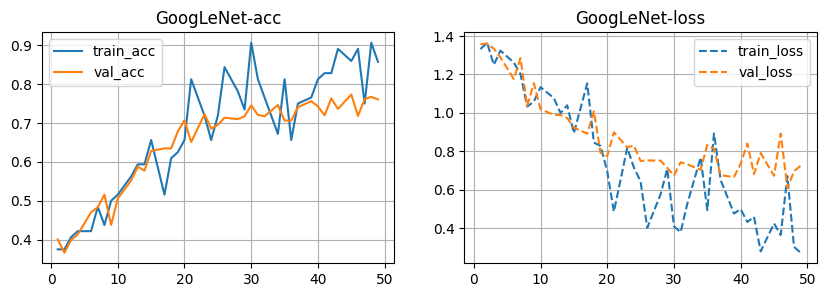

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#torch.save(model, "my_googlenet.pt")

#torch.save(model, '/content/gdrive/MyDrive/Colab Notebooks/models/my_googlenet.pt')

In [ ]:
#model = torch.load('./my_googlenet.pt')

model = torch.load('/content/gdrive/MyDrive/Colab Notebooks/models/my_googlenet.pt')

In [ ]:
trainer = Trainer(accelerator='auto')
trainer.validate(model, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.7769718766212463
        val_loss            0.6684965491294861
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.6684965491294861, 'val_acc': 0.7769718766212463}]

### Pre-trained googlenet 성능 확인하기

**torchvision.models에서 가져오기**
https://pytorch.org/vision/stable/models.html#classification

In [ ]:
import torchvision.models as models
#inception = models.inception_v3(pretrained=True)
model = models.googlenet(pretrained=True)
# resnet18 = models.resnet18(pretrained=True)
# alexnet = models.alexnet(pretrained=True)
# squeezenet = models.squeezenet1_0(pretrained=True)
# vgg16 = models.vgg16(pretrained=True)
# densenet = models.densenet161(pretrained=True)
# shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
# mobilenet_v2 = models.mobilenet_v2(pretrained=True)
# mobilenet_v3_large = models.mobilenet_v3_large(pretrained=True)
# mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)
# resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
# wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
# mnasnet = models.mnasnet1_0(pretrained=True)
# efficientnet_b0 = models.efficientnet_b0(pretrained=True)
# efficientnet_b1 = models.efficientnet_b1(pretrained=True)
# efficientnet_b2 = models.efficientnet_b2(pretrained=True)
# efficientnet_b3 = models.efficientnet_b3(pretrained=True)
# efficientnet_b4 = models.efficientnet_b4(pretrained=True)
# efficientnet_b5 = models.efficientnet_b5(pretrained=True)
# efficientnet_b6 = models.efficientnet_b6(pretrained=True)
# efficientnet_b7 = models.efficientnet_b7(pretrained=True)
# regnet_y_400mf = models.regnet_y_400mf(pretrained=True)
# regnet_y_800mf = models.regnet_y_800mf(pretrained=True)
# regnet_y_1_6gf = models.regnet_y_1_6gf(pretrained=True)
# regnet_y_3_2gf = models.regnet_y_3_2gf(pretrained=True)
# regnet_y_8gf = models.regnet_y_8gf(pretrained=True)
# regnet_y_16gf = models.regnet_y_16gf(pretrained=True)
# regnet_y_32gf = models.regnet_y_32gf(pretrained=True)
# regnet_x_400mf = models.regnet_x_400mf(pretrained=True)
# regnet_x_800mf = models.regnet_x_800mf(pretrained=True)
# regnet_x_1_6gf = models.regnet_x_1_6gf(pretrained=True)
# regnet_x_3_2gf = models.regnet_x_3_2gf(pretrained=True)
# regnet_x_8gf = models.regnet_x_8gf(pretrained=True)
# regnet_x_16gf = models.regnet_x_16gf(pretrainedTrue)
# regnet_x_32gf = models.regnet_x_32gf(pretrained=True)
# vit_b_16 = models.vit_b_16(pretrained=True)
# vit_b_32 = models.vit_b_32(pretrained=True)
# vit_l_16 = models.vit_l_16(pretrained=True)
# vit_l_32 = models.vit_l_32(pretrained=True)
# convnext_tiny = models.convnext_tiny(pretrained=True)
# convnext_small = models.convnext_small(pretrained=True)
# convnext_base = models.convnext_base(pretrained=True)
# convnext_large = models.convnext_large(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

**Github에서 가져오기**
https://github.com/pytorch/vision
https://pytorch.org/hub/pytorch_vision_googlenet/

In [ ]:
torch.hub.list('pytorch/vision:v0.12.0')

Downloading: "https://github.com/pytorch/vision/zipball/v0.12.0" to /root/.cache/torch/hub/v0.12.0.zip


['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'fcn_resnet101',
 'fcn_resnet50',
 'googlenet',
 'inception_v3',
 'lraspp_mobilenet_v3_large',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'raft_large',
 'raft_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_8gf',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth

  0%|          | 0.00/49.7M [00:00<?, ?B/s]
  2%|▏         | 1.03M/49.7M [00:00<00:04, 10.8MB/s]
 23%|██▎       | 11.3M/49.7M [00:00<00:

#### Imagenet Class Label 읽어오기

In [ ]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2023-06-20 12:45:31--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-06-20 12:45:31 (132 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [ ]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [ ]:
p(categories[:5],)
p(categories[-5:])
len(categories)

[]:
Type: <class 'list'>
Values: ['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead']
[]:
Type: <class 'list'>
Values: ['earthstar', 'hen-of-the-woods', 'bolete', 'ear', 'toilet tissue']


1000

Type: <class 'list'>
Values: ['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead']
Type: <class 'list'>
Values: ['earthstar', 'hen-of-the-woods', 'bolete', 'ear', 'toilet tissue']
1000

#### Inference

In [ ]:
model.eval() ##
imgs, labels = next(iter(train_loader)) #(64,img),(64,label)
p(labels)
outputs = model(imgs) # (64,1000)

idx = torch.nn.functional.softmax(outputs, dim=1)
# Show top categories per image
top5_prob, top5_catid = torch.topk(idx, 1) #(64,1),(64,1)
for i in range(top5_prob.size(0)): # 64
      print(f'{CLASS_test[labels[i]]:10s}:{categories[top5_catid[i,0]]:15s},{top5_prob[i,0]:0.4f}')


[]:
Shape:torch.Size([64])
Type: <class 'torch.Tensor'>
Values: tensor([1, 1, 2, 3, 1, 3, 3, 4, 2, 1, 4, 0, 0, 4, 4, 0, 1, 2, 3, 4, 1, 4, 2, 3,
        1, 3, 1, 1, 3, 1, 3, 1, 0, 0, 2, 3, 4, 1, 2, 3, 0, 0, 0, 0, 3, 4, 1, 3,
        3, 2, 0, 4, 0, 3, 2, 4, 2, 4, 1, 2, 4, 0, 0, 4])
dandelion :sea urchin     ,0.2925
dandelion :sea urchin     ,0.2514
roses     :head cabbage   ,0.2486
sunflowers:sliding door   ,0.1896
dandelion :hummingbird    ,0.1183
sunflowers:sea anemone    ,0.4957
sunflowers:book jacket    ,0.0860
tulips    :daisy          ,0.5054
roses     :mobile home    ,0.1120
dandelion :feather boa    ,0.6167
tulips    :spatula        ,0.0617
daisy     :daisy          ,0.8501
daisy     :vase           ,0.2088
tulips    :abacus         ,0.2030
tulips    :bell pepper    ,0.2341
daisy     :daisy          ,0.9487
dandelion :daisy          ,0.2557
roses     :jellyfish      ,0.1180
sunflowers:daisy          ,0.5458
tulips    :daisy          ,0.2368
dandelion :daisy          ,0.4475
tulip

In [ ]:
# categories와 CLASS_train 겹치는 경우
# categorie id와 name 확인
for i in range(len(categories)):
  if categories[i] in CLASS_train:
    print( i, categories[i])

985 daisy
